# Chapter: 3 The potential field method


In the previous chapter we have seen how using Kriging we can interpolate a whole domain given **input data** at certain position **x** (author comment I have to review all the nomenclature using Jaspers I guess) and a **covariance function** derived from a **variogram** that describe the spatial correlation of that **input data**.

Here, I will explain how we can take advantage of the Kriging properties in order to interpolate the actual structural geology rather a physical property. The trick is to assign an arbitrary value to every interface between the distinct facies of the system. This creates a potential field where the value of the interfaces are fixed and the rest of the domain is characterize but the kriging interpolator.

Analogous, to define this so called **potential field** we can use the derivative of the above mentionated potential field as **input data**. This type information could we seen as geological orientations.

Therefore the parametization of the domain will consist of:

- Input data:
+ Contact points
+ Orientations

- Variogram
+ Range
+ Sill
+ Nugget effect

In the following lines we will develop these concepts and finally how we can combine all these information in a Universal co-kriging scheme in order to generate implicit geological structural model.

## Kriging the "value of the potential field"

First of all lets start with a simple kriging of the value of the potential field in order to illustrate what do we mean by "potential field". Lets imagine the following 2D problem:


In [1]:
# Importing stuff
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import sklearn.metrics as me
from __future__ import division
%matplotlib inline
# load libraries and set plot parameters
import numpy as np
#import PrettyTable as pt

import matplotlib.pyplot as plt
import importlib
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75


plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

#plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
#plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

import sys, os
sys.path.append("/home/bl3/PycharmProjects/GeMpy/")
sys.path.append("/home/bl3/PycharmProjects/pygeomod/pygeomod")
import GeoMig
import Visualization

importlib.reload(GeoMig)
importlib.reload(Visualization)


ImportError: No module named 'GeoMig'

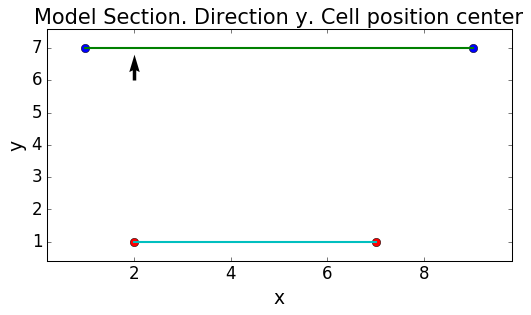

In [10]:
# We plot the initial data
data = Visualization.GeoPlot()
data.set_resolutions(10,10,10)

layer_1 = np.array([[1,5,7], [9,5,7]], dtype = "float32")

layer_2 = np.array([[2,5,1],[7,5,1]], dtype = "float32")

dip_pos_1 = np.array([2,5,6], dtype = "float32")
dip_pos_2 = np.array([6.,4,6], dtype = "float32")
dip_pos_3 = np.array([8,4,5], dtype = "float32")
dip_angle_1 = float(0)
dip_angle_2 = float(45)


data.set_layers([layer_1,layer_2])
data.dips = np.asarray([dip_pos_1])#, dip_pos_3])
data.dips_angles = np.asarray([dip_angle_1], dtype="float32")
data.azimuths = np.asarray([0], dtype="float32")
data.polarity = np.asarray([1], dtype="float32")

data.calculate_gradient()

rest = np.vstack((i[1:] for i in data.layers))
ref = np.vstack((np.tile(i[0],(np.shape(i)[0]-1,1)) for i in data.layers))
data.rest = rest.astype("float32")
data.ref = ref.astype("float32")
data.dips = data.dips.astype("float32")
data.dips_angles = data.dips_angles.astype("float32")
#type(dips_angles)

data.plot_potential_field_2D(direction="y", linear_interpolation=True)

Here, we have the two types of parameters that we are using in this type of interpolation. For the sake of simplicity lets divide the problem into pieces. Lets start with the contact points.

### Kriging the potential field given contact points

The first thing we need to notice here is that usually we perform Kriging to a "property". In this case our property is arbitrary as long as every interface has the same value (the red and blue dots). As we will see later on, we will exploit the fact that we do not care the real value of the **potential field** to simplify (an avoid artifacts) the math. But so far lets say that:

- The red dots have value 1
- The blue dots have value 2

*Are you telling me that because you do not have anything to interpolate you are going to interpolate arbitrary values but the result is not going to be arbitrary? You should spend less time with mathematicians.*

Wait and you will see *italic font*. At this point we just need to perform a normal Kriging interpolation (author comment: maybe ordinary kriging lets see). Therefore, first of all we need to choose a variogram/covariance function and the chosen one is cuadratic (AC: look for why):

In [ ]:
# Code variograms 
from ipywidgets import widgets
from IPython.html.widgets import interact
def cov_cubic_f(r,a = 6, c_o = 1):
    if r <= a:
        return c_o*(1-7*(r/a)**2+35/4*(r/a)**3-7/2*(r/a)**5+3/4*(r/a)**7)
    else:
        return 0
def cov_cubic_d1_f(r,a = 6., c_o = 1):
    SED_dips_dips = r
    f = c_o
    return  (f * ((-14 /a ** 2) + 105 / 4 * SED_dips_dips / a ** 3 -
            35 / 2 * SED_dips_dips ** 3 / a ** 5 + 21 / 4 * SED_dips_dips ** 5 / a ** 7))

def cov_cubic_d2_f_p(r, a = 6, c_o = 1):
    SED_dips_dips = r
    f = c_o
    return  (f * (105/4*SED_dips_dips/a-

                  105/2*SED_dips_dips**3/a**3+105/4**SED_dips_dips**5/a**5))    
def cov_cubic_d2_f(r, a = 6, c_o = 1):
    SED_dips_dips = r
    f = c_o
    return 7*f*(9*r**5-20*a**2*r**3+15*a**4*r-4*a**5)/(2*a**7)


def plot_cd1__r(a, c_o):
    x = np.linspace(0,12,50)
    y = [cov_cubic_d1_f(i, a = a, c_o = c_o) for i in x]
    print (cov_cubic_d1_f(0, a = a, c_o = c_o),cov_cubic_d1_f(a, a = a, c_o = c_o),) 
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(x,c_o-np.asarray(y))
    plt.hlines(0,0,12, linestyles = "--")
    plt.title("Variogram")
    plt.margins(0,0.1)
    
    ax2 = fig.add_subplot(122)
    ax2.plot(x,np.asarray(y))
   # ax2.scatter(0,c_o)
    plt.title("Covariance Function")
    plt.tight_layout()
    plt.margins(0,0.1)
    plt.suptitle('C\'/r')
    
def plot_cd2(a, c_o):
    x = np.linspace(0,12,50)
    y = [cov_cubic_d2_f(i, a = a, c_o = c_o) for i in x]
    print (cov_cubic_d2_f(0, a = a, c_o = c_o), cov_cubic_d2_f(a, a = a, c_o = c_o)) 
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(x,np.asarray(y))
    plt.hlines(0,0,12, linestyles = "--")
    plt.title("Variogram")
    plt.margins(0,0.1)
    
    ax2 = fig.add_subplot(122)
    ax2.plot(x,np.asarray(y))
   # ax2.scatter(0,c_o)
    plt.title("Covariance Function")
    plt.tight_layout()
    plt.margins(0,0.1)
    plt.suptitle('C\'\'')
    
def plot_cd2_sub_cd1__r(a, c_o):
    x = np.linspace(0,12,50)
    y1 = np.asarray([cov_cubic_d2_f(i, a = a, c_o = c_o) for i in x])
    y2 = np.asarray([cov_cubic_d1_f(i, a = a, c_o = c_o) for i in x])
    y = y2-y1
    print (cov_cubic_d2_f(0, a = a, c_o = c_o), cov_cubic_d2_f(a, a = a, c_o = c_o)) 
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(x,c_o-np.asarray(y))
    plt.hlines(0,0,12, linestyles = "--")
    plt.title("Variogram")
    plt.margins(0,0.1)
    
    ax2 = fig.add_subplot(122)
    ax2.plot(x,np.asarray(y))
   # ax2.scatter(0,c_o)
    plt.title("Covariance Function")
    plt.tight_layout()
    plt.margins(0,0.1)
    plt.suptitle('C\'\' - C\'/r')

def plot_potential_var(nugget_effect = 0, c_o = 1,):
    x = np.linspace(0,12,50)
    y = [cov_cubic_f(i, a = 30, c_o = c_o) for i in x]
    
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(x,c_o-np.asarray(y)+nugget_effect)
    plt.hlines(0,0,12, linestyles = "--")
    plt.title("Variogram")
    plt.margins(0,0.1)
    
    ax2 = fig.add_subplot(122)
    ax2.plot(x,np.asarray(y))
    ax2.scatter(0,nugget_effect+c_o)
    plt.title("Covariance Function")
    plt.tight_layout()
    plt.margins(0,0.1)
    plt.suptitle('Potential')

    
def plot_potential_direction_var( c_o, a):
    x = np.linspace(0,12,50)
    y = [cov_cubic_d1_f(i, a = a, c_o = c_o) for i in x]
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(x,-np.asarray(y))
    plt.hlines(0,0,12, linestyles = "--")
    plt.title("Variogram")
    plt.margins(0,0.1)
    
    ax2 = fig.add_subplot(122)
    ax2.plot(x,np.asarray(y))
    #ax2.scatter(0,c_o)
    plt.title("Cross-Covariance Function")
    plt.tight_layout()
    plt.margins(0,0.1)
    plt.suptitle('Co-Krigin Potential to one direction', verticalalignment = "bottom")

def plot_directionU_directionU_var(nugget_effect = 0, c_o = 1):
    x = np.linspace(0.01,12,50)
    d1 = [cov_cubic_d1_f(i, a = 30, c_o = c_o) for i in x]
    d2 = [cov_cubic_d2_f(i, a = 30, c_o = c_o) for i in x]
    y = -(d2-d1/x)-d1/x # (0.5*x**2)/(x**2)*
    
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(x,c_o-np.asarray(y)+nugget_effect)
#    plt.hlines(0,0,12, linestyles = "--")
    plt.title("Variogram")
    plt.margins(0,0.1)
    
    ax2 = fig.add_subplot(122)
    ax2.plot(x,np.asarray(y))
    ax2.scatter(0,nugget_effect+y[0], s = 20)
   # print(y)
    plt.title("Covariance Function")
    plt.tight_layout()
    plt.margins(0,0.1)
    plt.suptitle('Gradient: One direction (XYZ)', verticalalignment = "bottom")
    
def plot_directionU_directionV_var(nugget_effect = 0, c_o = 1):
    x = np.linspace(0.01,12,50)
    d1 = [cov_cubic_d1_f(i, a = 10, c_o = c_o) for i in x]
    d2 = [cov_cubic_d2_f(i, a = 10, c_o = c_o) for i in x]
    y = -(d2-d1/x) # (0.5*x**2)/(x**2)*
    
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(x,c_o-np.asarray(y)+nugget_effect)
#    plt.hlines(0,0,12, linestyles = "--")
    plt.title("Variogram")
    plt.margins(0,0.1)
    
    ax2 = fig.add_subplot(122)
    ax2.plot(x,np.asarray(y))
    ax2.scatter(0,nugget_effect+y[0], s = 20)
    #print(y)
    plt.title("Covariance Function")
    plt.tight_layout()
    plt.margins(0,0.1)
    plt.suptitle('Gradient: 90 degree direction (XYZ)', verticalalignment = "bottom")

In [362]:
cov_cubic_d1_f(4, a = 10, c_o = 100/14/3), cov_cubic_d2_f(4, a = 10, c_o = 100/14/3)

(-0.10872000000000005, 0.06768)

In [355]:
cov_cubic_d1_f(4, a = 10, c_o = -1/3),

(-0.10872000000000005,)

In [347]:
c = 100/14/3
a = 10
x = 4
c*(21*x**6/(4*a**7)-35*x**4/(2*a**5)+105*x**2/(4*a**3)-14*x/a**2)/4


-0.10872000000000005

In [358]:
c*(-14/a**2+105*x/(4*a**3)-35*x**3/(2*a**5)+21*x**5/(4*a**7))

-0.10872000000000005

In [360]:
c * ((-14 /a ** 2) + 105 / 4 * x / a ** 3 -35 / 2 * x ** 3 / a ** 5 + 21 / 4 * x ** 5 / a ** 7)

-0.10872000000000005

-0.33333333333333337 0.0


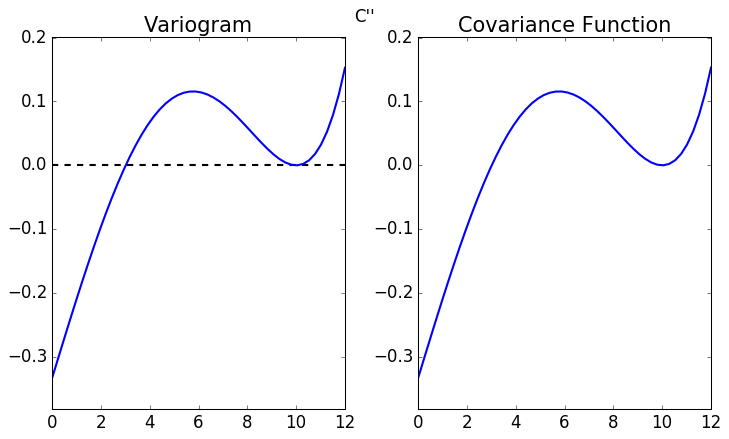

In [323]:
plot_cd2(10, 10**2/14/3)

0.0 0.0


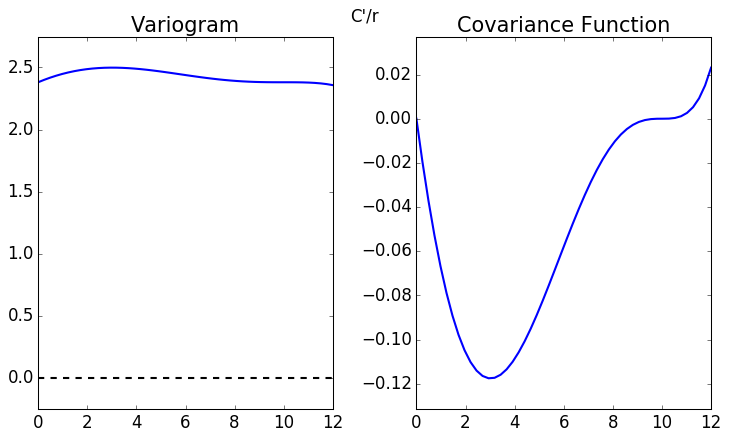

In [353]:
plot_cd1__r(10,10**2/14/3)

-0.33333333333333337 0.0


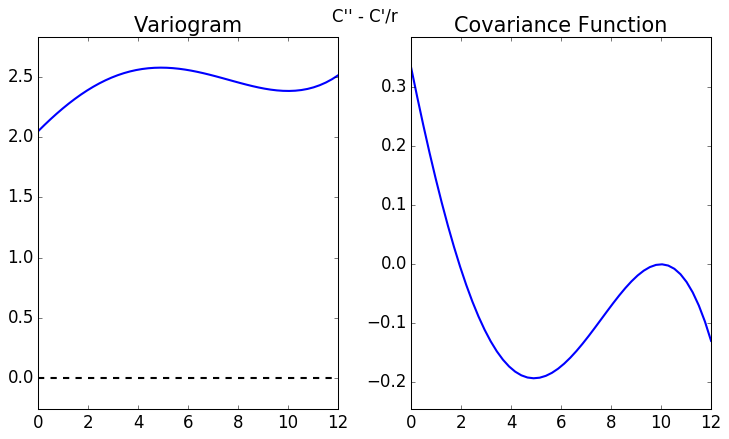

In [354]:
plot_cd2_sub_cd1__r(10,10**2/14/3)

## This are covariances of a property

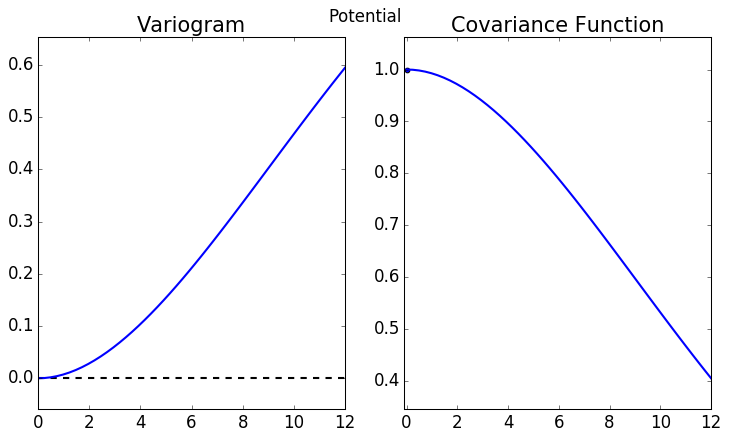

In [234]:
#Plotting variogram and covariance of the potential field
plot_potential_var(nugget_effect = 0.00001, c_o =1)

In [238]:
plot_directionU_directionU_var(a =10 ,c_o=1 )

TypeError: plot_directionU_directionU_var() got an unexpected keyword argument 'a'

### This are Cross-covariances

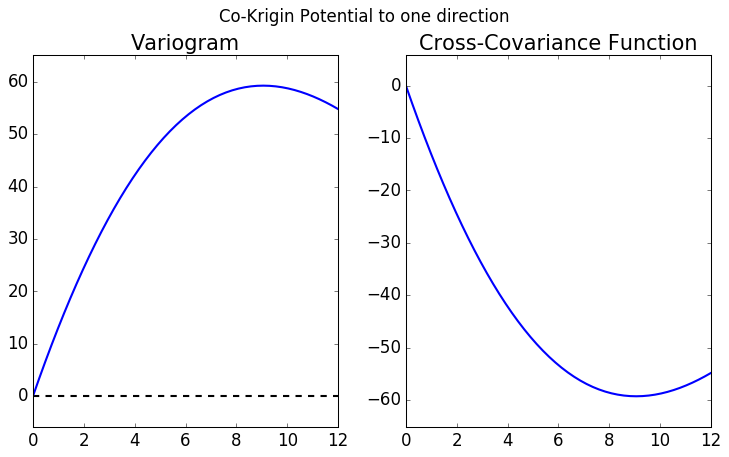

In [232]:
# Plotting variogram and covariance cov potential field to direction
plot_potential_direction_var(c_o= 30*30)

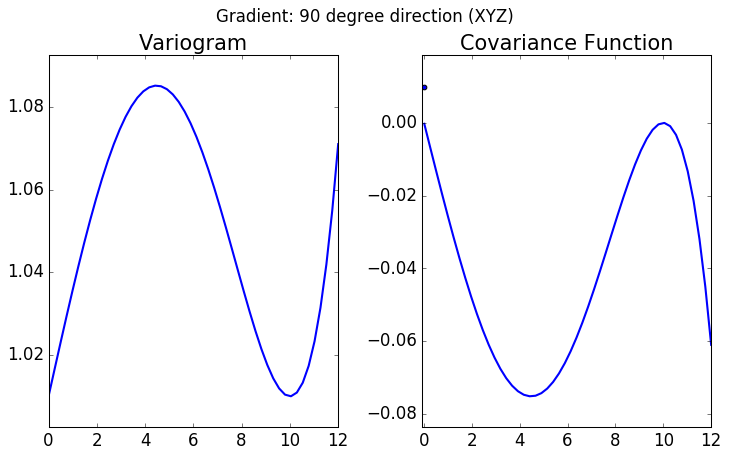

In [207]:
# Plotting variogram and covariance cov direction to direction
plot_directionU_directionV_var(nugget_effect=0.01,c_o= 1)

- The spatial covariance model of the primary attribute (e.g., potential).
- The spatial covariance model of other atributes attribute (e.g., derivation x, der y der z).
- The spatial cross-covariance model of attributes 
    + Potential-x; Potential-y; Potential-z
    + x-y, x-z
    + y-z, y-x
    + z-x, z-y